# Multivariate linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import stats 
from scipy.stats import pearsonr
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

#### Reading and displaying csv files

In [2]:
salary_data = pd.read_csv('salary.csv')
salary_meta = pd.read_csv('Salary metadata.csv', sep=';')

display(salary_data.head())
display(salary_meta)

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this field
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,"Market value (1 = salary at market value for position, <1 salary lower than market value for position, >1 salary higher than market value for position)"
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,"Has other post-secondary qualification (0 = no, 1 = yes)"
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 = Executive)"
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3 = Human Resources, 4 = Marketing)"


#### Missing values

In [3]:
salary_data.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

In [4]:
# filling missing values with mean

salary_data['salary'].fillna(salary_data['salary'].mean(),inplace=True)

In [5]:
# confirmation from missing values
salary_data.isnull().sum().sum()

0

#### checking for outliers

In [6]:
#finding Interquatile range
q1 = salary_data.salary.quantile(0.25)
q3 = salary_data.salary.quantile(0.75)
iqr = q3-q1
print('interquartile Range =',iqr)

#Boundries
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
print("lower bound =", lower_bound)
print("upper bound =", upper_bound)



interquartile Range = 20306.25
lower bound = 9540.625
upper bound = 90765.625


In [7]:
#
new_salary_data = salary_data.loc[(salary_data['salary'] > lower_bound) & (salary_data['salary'] < upper_bound)].reset_index(drop=True)
print('new salary data shape =', new_salary_data.shape)

new salary data shape = (512, 11)


In [8]:
outliers = salary_data.loc[(salary_data['salary'] < lower_bound) | (salary_data['salary'] > upper_bound)]
outliers

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
280,91405.0,0,23,14,1.18,1,0,3,1,1,0
377,96156.0,20,12,12,1.19,1,0,3,1,1,2


## 1. Exploratory data analys (EDA)

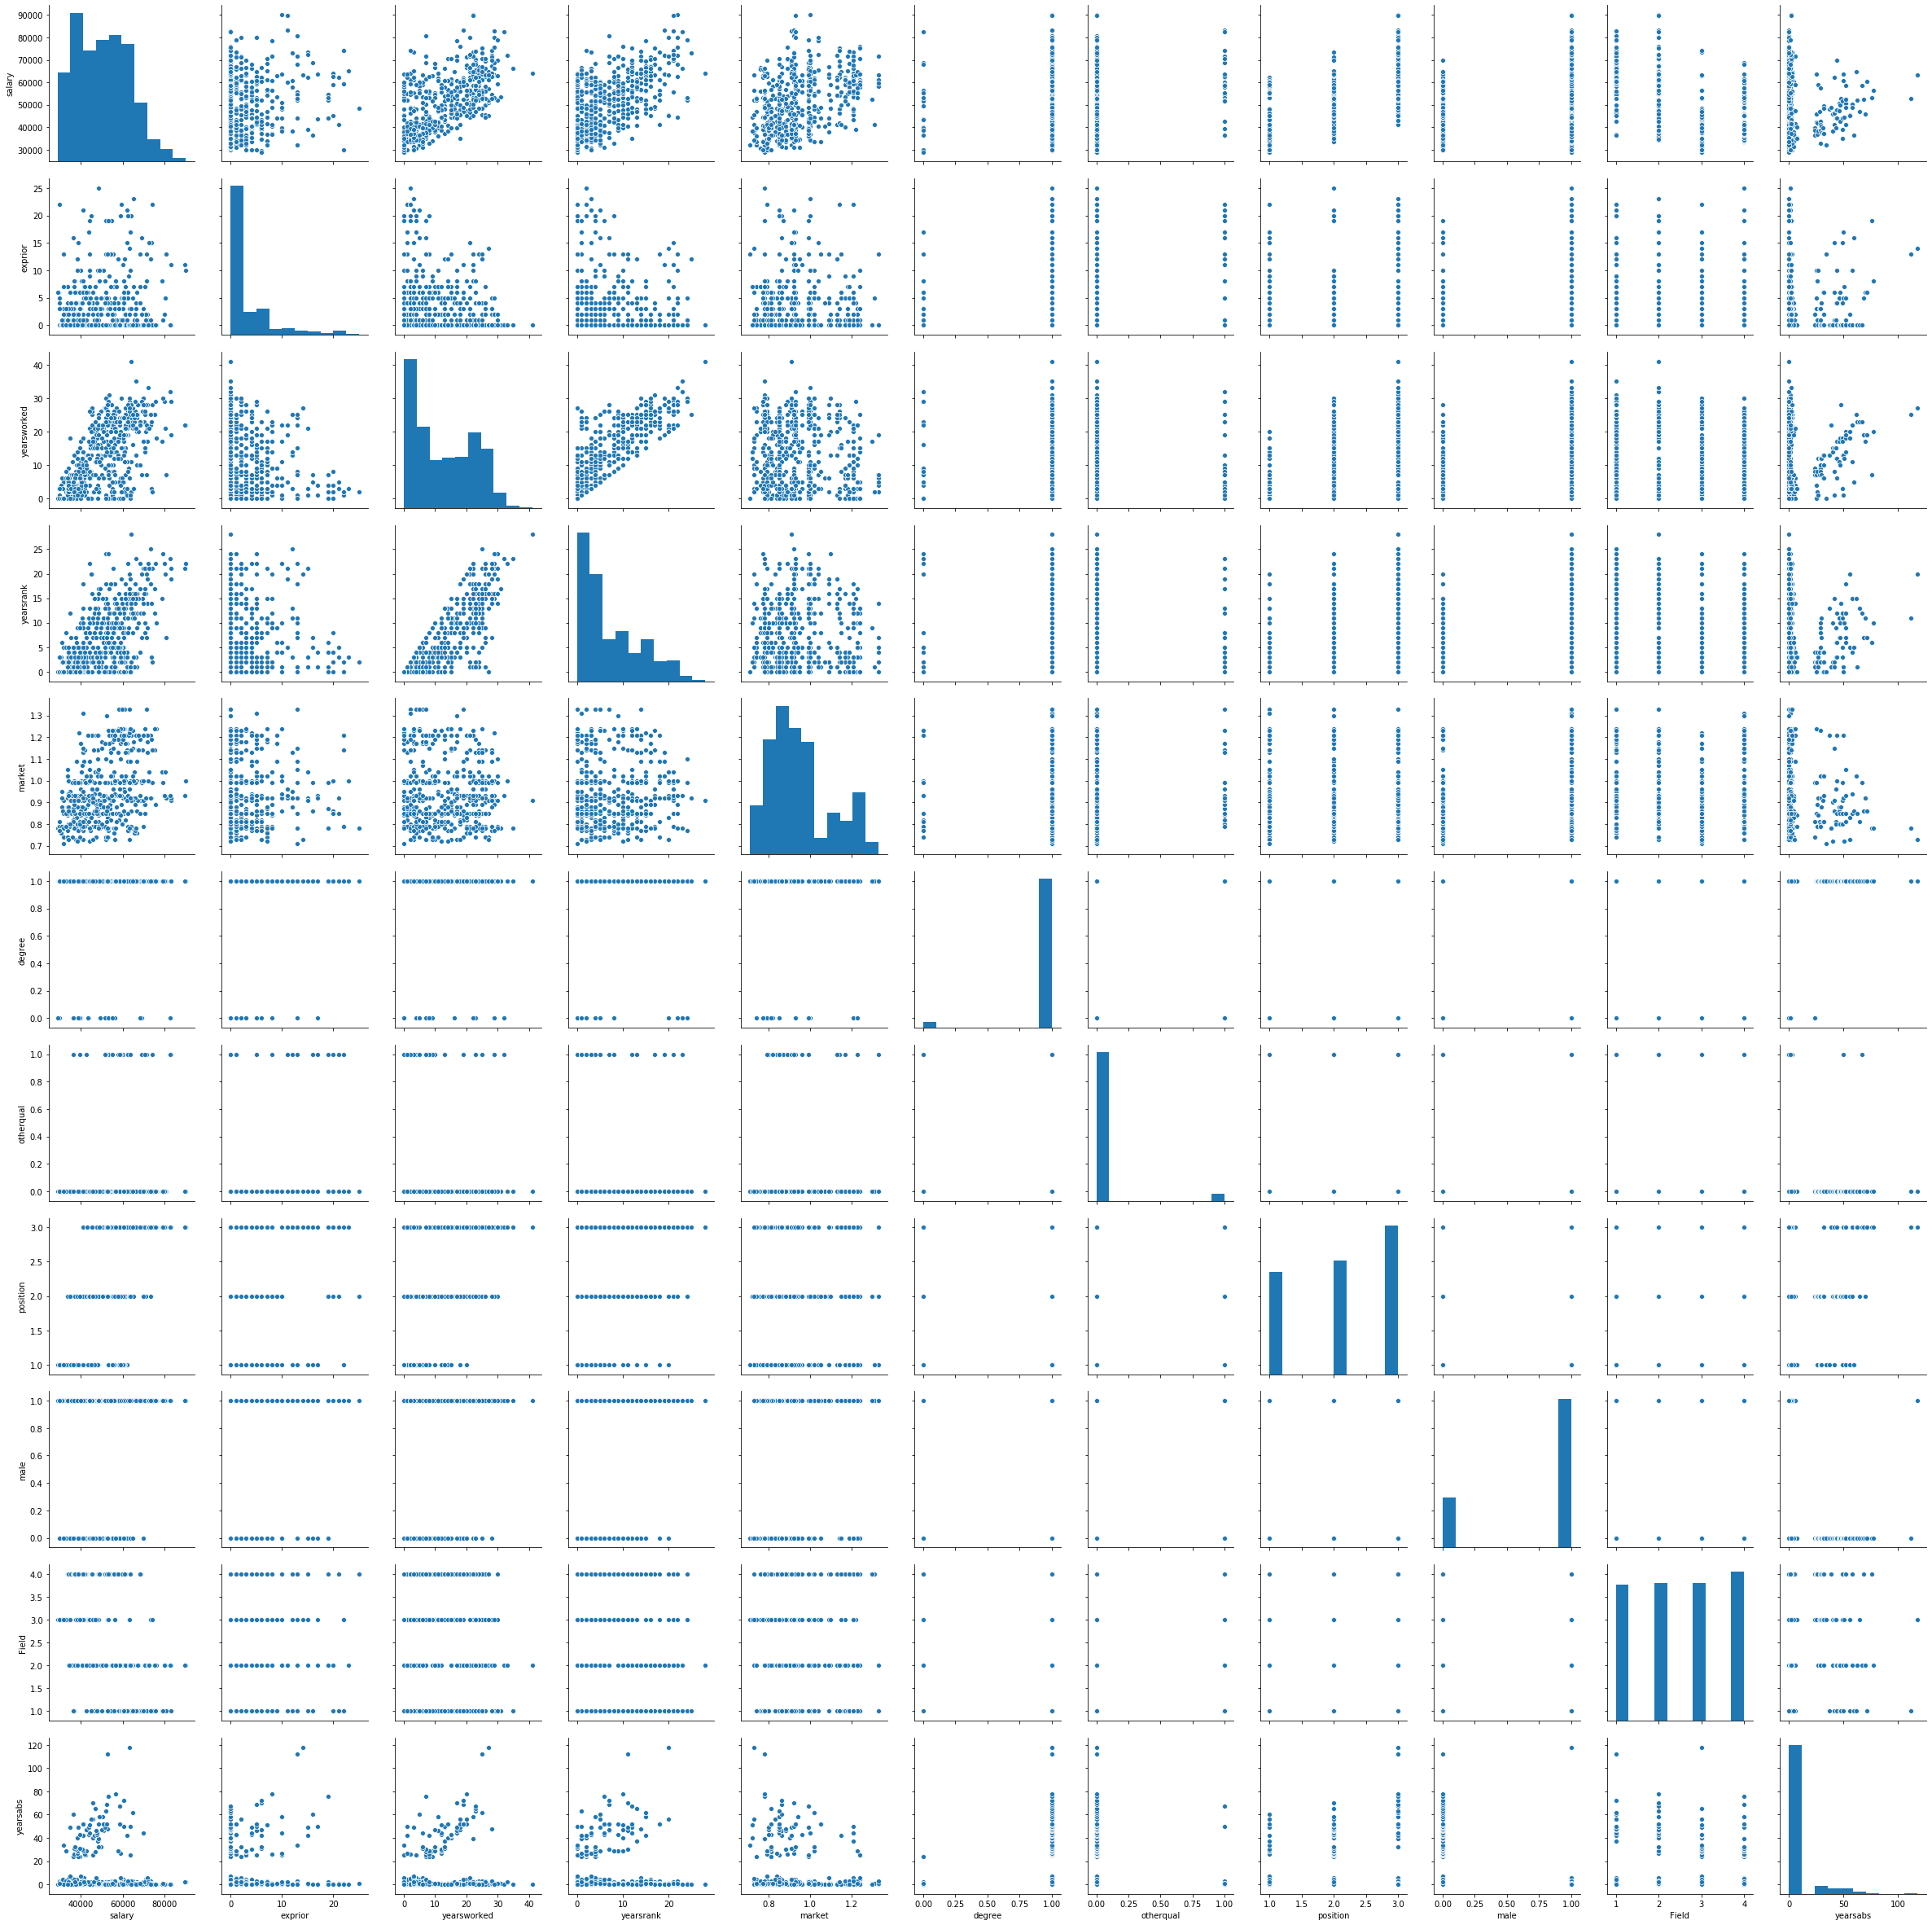

In [9]:
#
_= sns.pairplot(new_salary_data, height =3)

#### -  A descriptive statistics table to further characterise and describe the population under investigation

In [10]:
new_salary_data.corr()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
salary,1.000000,0.102471,0.632135,0.613411,0.397153,0.043012,0.173972,0.704892,0.362302,-0.493484,-0.066496
exprior,0.102471,1.000000,-0.248118,-0.071533,-0.045262,-0.051132,0.269539,0.112165,0.043824,-0.041153,0.135723
yearsworked,0.632135,-0.248118,1.000000,0.813662,-0.074319,0.028088,-0.040123,0.747183,0.278351,-0.259999,0.056364
yearsrank,0.613411,-0.071533,0.813662,1.000000,-0.032917,0.005836,0.007835,0.483265,0.236262,-0.260419,0.037028
market,0.397153,-0.045262,-0.074319,-0.032917,1.000000,0.035405,0.023147,-0.020056,0.178630,-0.217271,-0.165736
degree,0.043012,-0.051132,0.028088,0.005836,0.035405,1.000000,-0.214591,0.042989,0.061227,-0.097773,0.029584
otherqual,0.173972,0.269539,-0.040123,0.007835,0.023147,-0.214591,1.000000,0.161575,0.016332,-0.078059,-0.017945
position,0.704892,0.112165,0.747183,0.483265,-0.020056,0.042989,0.161575,1.000000,0.316646,-0.284845,0.031296
male,0.362302,0.043824,0.278351,0.236262,0.178630,0.061227,0.016332,0.316646,1.000000,-0.126357,-0.621940
Field,-0.493484,-0.041153,-0.259999,-0.260419,-0.217271,-0.097773,-0.078059,-0.284845,-0.126357,1.000000,-0.002017


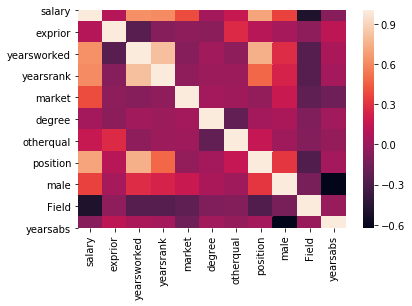

In [11]:
correlation_map = sns.heatmap(new_salary_data.corr())


In [12]:
new_salary_data.describe()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,50695.574473,2.898438,12.833984,7.029297,0.947598,0.964844,0.044922,2.128906,0.750000,2.535156,7.005859
std,12408.394738,4.739128,9.452413,6.416186,0.148936,0.184355,0.207335,0.819876,0.433436,1.125550,16.901868
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,1.000000,0.000000,1.000000,0.750000,2.000000,0.000000
50%,50052.000000,0.500000,12.000000,5.000000,0.920000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000
75%,60162.250000,4.000000,22.000000,12.000000,1.020000,1.000000,0.000000,3.000000,1.000000,4.000000,2.000000
max,90082.000000,25.000000,41.000000,28.000000,1.330000,1.000000,1.000000,3.000000,1.000000,4.000000,118.000000


##### variables that seemed to be good predictors of the salary.
By observing the above DataFrame we see a correlation in some of the features which are:
* Position
* Yearsrank
* Yearsworked
* Field

##### variables need to be transformed to be able to use them in a linear regression model.
* Variables that need to be transformed are Field and position because they are catergorical variable. Categorical variables require special attention in regression analysis because, continuous variables, they cannot by entered into the regression equation just as they are.  Instead, they need to be recoded into a series of variables which can then be entered into the regression model.

## 2. Performing some basic features engineering by one-hot encoding the variable Field into three dummy variables, using HR as the reference category.

In [13]:
#creating dummies
field_dummies = pd.get_dummies(new_salary_data['Field']) 
# position_dummies = pd.get_dummies(new_salary_data['position'])

#renaming dummies
field_dummies = field_dummies.rename(columns={1: "Engineering",
                                         2: "Finance", 
                                         3: "Human Resources", 
                                         4: "Marketing"})

# position_dummies = position_dummies.rename(columns={1: "Junior Employee", 
#                                                     2: "Manager", 
#                                                     3:"Executive"})

#merging the field dummies with salary
merged_dummies = pd.concat([new_salary_data,field_dummies] ,axis = 'columns', ignore_index=False)
merged_dummies.reset_index(drop=True, inplace=True)

merged_dummies.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs,Engineering,Finance,Human Resources,Marketing
0,53000.0,0,0,0,1.17,1,0,1,1,3,0,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2,0,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,1,4,1,0,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1,0,0,0,1


In [15]:
# Dropiing columns not needed
salary_predictors = merged_dummies.drop(["exprior", 
                                       "market",
                                       "degree",
                                       "otherqual",
                                       "male",
                                       "Field",
                                       "yearsabs"], axis = 'columns')

salary_predictors.head()

,salary,yearsworked,yearsrank,position,Engineering,Finance,Human Resources,Marketing
0,53000.0,0,0,1,0,0,1,0
1,58000.0,0,0,1,0,1,0,0
2,45500.0,0,0,1,0,0,1,0
3,35782.0,2,1,1,0,0,0,1
4,34731.0,2,2,1,0,0,0,1


## 3. Performing correlation and statistical significance analysis to validate the relationship salary to each of the potential predictor variables:

 
* Pearson correlation coeffificent and plot the correspnding correlation matrix

In [16]:
yearsworked_vs_salary = pearsonr(salary_predictors['yearsworked'] , salary_predictors['salary'])
print('Years worked vs salary = ', yearsworked_vs_salary )

yearsrank_vs_salary = pearsonr(salary_predictors['yearsrank'] , salary_predictors['salary'])
print('Years rank vs salary = ', yearsrank_vs_salary )

position_vs_salary = pearsonr(salary_predictors['position'] , salary_predictors['salary'])
print('position vs salary = ', position_vs_salary )

# junior_employee_vs_salary = pearsonr(salary_predictors['Junior Employee'] , salary_predictors['salary'])
# print('Junior employee vs salary = ', junior_employee_vs_salary )

# manager_vs_salary = pearsonr(salary_predictors['Manager'] , salary_predictors['salary'])
# print('Manager vs salary = ', manager_vs_salary )

# executive_vs_salary = pearsonr(salary_predictors['Executive'] , salary_predictors['salary'])
# print('Executive vs salary = ', executive_vs_salary )

engineering_vs_salary = pearsonr(salary_predictors['Engineering'] , salary_predictors['salary'])
print('Engineering vs salary = ', engineering_vs_salary )

finance_vs_salary = pearsonr(salary_predictors['Finance'] , salary_predictors['salary'])
print('Finance vs salary = ', finance_vs_salary )

hr_vs_salary = pearsonr(salary_predictors['Human Resources'] , salary_predictors['salary'])
print('HR vs salary = ', hr_vs_salary )

marketing_vs_salary = pearsonr(salary_predictors['Marketing'] , salary_predictors['salary'])
print('Marketing vs salary = ', marketing_vs_salary )

predictors_pearson_correlation = salary_predictors.corr(method ='pearson')
display(predictors_pearson_correlation)

Years worked vs salary =  (0.632134532200623, 1.7755624016355923e-58)
Years rank vs salary =  (0.6134113329373261, 3.0361406890501405e-54)
position vs salary =  (0.7048916005710117, 4.2358656892576807e-78)
Engineering vs salary =  (0.41457174005134145, 1.1002853477338155e-22)
Finance vs salary =  (0.24482591357592948, 2.001579713570849e-08)
HR vs salary =  (-0.43838554319421147, 1.8516352407772795e-25)
Marketing vs salary =  (-0.21335795457045031, 1.1038998304413863e-06)


,salary,yearsworked,yearsrank,position,Engineering,Finance,Human Resources,Marketing
salary,1.000000,0.632135,0.613411,0.704892,0.414572,0.244826,-0.438386,-0.213358
yearsworked,0.632135,1.000000,0.813662,0.747183,0.215123,0.152177,-0.267499,-0.096198
yearsrank,0.613411,0.813662,1.000000,0.483265,0.193009,0.172118,-0.240300,-0.120721
position,0.704892,0.747183,0.483265,1.000000,0.256127,0.142596,-0.305822,-0.089252
Engineering,0.414572,0.215123,0.193009,0.256127,1.000000,-0.322988,-0.322988,-0.339993
Finance,0.244826,0.152177,0.172118,0.142596,-0.322988,1.000000,-0.326425,-0.343611
Human Resources,-0.438386,-0.267499,-0.240300,-0.305822,-0.322988,-0.326425,1.000000,-0.343611
Marketing,-0.213358,-0.096198,-0.120721,-0.089252,-0.339993,-0.343611,-0.343611,1.000000


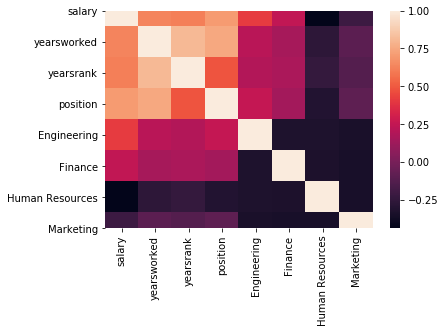

In [27]:
sns.heatmap(salary_predictors.corr(),)

In [28]:
X = salary_predictors
pd.Series([variance_inflation_factor(X.values, x) 
               for x in range(X.shape[1])], 
              index=X.columns)


salary             3.356182 
yearsworked        6.002214 
yearsrank          4.093290 
position           3.749216 
Engineering        10.969668
Finance            9.841958 
Human Resources    6.173754 
Marketing          7.813323 
dtype: float64

In [29]:
X = salary_predictors.drop(['salary','position','yearsrank'], axis = 1)
y = salary_predictors.salary

In [31]:
X_train,X_test,y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=10)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(358, 5) (154, 5) (358,) (154,)


In [32]:
lm = LinearRegression()
# fit the model to the training data
results = lm.fit(X_train,y_train)
print('Intercept:',results.intercept_)

Intercept: 42186.398082119325


In [33]:
coeff_df = pd.DataFrame(lm.coef_,X_test.columns,columns=['Coefficient'])
coeff_df

,Coefficient
yearsworked,673.676562
Engineering,6299.869727
Finance,4469.938851
Human Resources,-6449.594670
Marketing,-4320.213908
